# Human Activity Recognition: 3 Different Approaches

This notebook is broken down into four main sections:

1. Data Summary & Analysis Goals
2. EDA
3. Modeling
4. Conclusion & Next Steps

Each of these sections will be broken down into subsections and will have information that is needed to create a cohesive report.

###### Training on AWS

I chose to look at this data set from more than the "traditional" approach, which led to some time consuming and computationally expensive parts of the analysis. These were run on AWS, on a **c5d.4xlarge** instance (32 Gib RAM, 16 Cores) to be specific. The [setup file](setup.sh) can be sourced on the instance to set up the appropriate environment (Downloads Anaconda, the Imbalanced-Learn package, adds anaconda to PATH, and adds the src/ directory to the PYTHONPATH).

### Data Summary & Analysis Goals

#### Data Summary

15 participants wore an accelerometer mounted to their chest while performing seven different activities:

1. Working at Computer
2. Standing up, Walking and Going Up/Down Stairs
3. Standing
4. Walking
5. Going Up/Down Stairs
6. Walking and Talking w/ Someone
7. Talking while Standing

The accelerometer captured acceleration measurements in **three dimensions - X, Y and Z**. Each participant's measurement are in their own file, along with the activity they were performing at that time. Each subject has 6,000 - 16,000 observations, totaling 1,926,896 observations.

The data I will be working with (shown below) has 6 columns:

1. seq - The sequence number (per participant) that the activity was performed in.
2. x_acc - Accelerometer measurements in the **X** dimension.
3. y_acc - Accelerometer measurements in the **Y** dimension.
4. z_acc - Accelerometer measurements in the **Z** dimension.
5. label - The label of the activity being performed.
6. subject - The study participant ID.

In [48]:
from src.format_data import *
files = [file[3:] for file in files]

# check src/format_data for aggregate_subjects() function
df = aggregate_subjects(files=files)
df.head()

,seq,x_acc,y_acc,z_acc,label,subject
0,0,1502.0,2215.0,2153.0,Working at Computer,1
1,1,1667.0,2072.0,2047.0,Working at Computer,1
2,2,1611.0,1957.0,1906.0,Working at Computer,1
3,3,1601.0,1939.0,1831.0,Working at Computer,1
4,4,1643.0,1965.0,1879.0,Working at Computer,1


*A note on data cleaning - There was one instance at the end of each file that had the label set as '0'. Since this was consistent across all data files, and these instances were all after the sequences of data with the activity label '7', I assigned these instances the label of '7' (aka 'Talking while Standing'), since '0' was not a valid activity given in the problem description.*

#### Analysis Goals

The goal of this analysis is not only to be able to predict what activity is being performed based on the accelerometer measurements (or any features that are derived from these measurements), but, more importantly, to understand:

* How the distribution of data across subjects and classes can affect model building and prediction accuracy.
* The data limitations.
* How to bring in the sequential nature of the problem.
* The intution behind the better performing models.
* How different end goals can affect the predictive methodology used.

### EDA (Exploratory Data Analysis)

#### Data Distribution

In order to build a reliable and generalizable model to predict the activity a person is performing, checking for any implicit bias in the data itself is a must.

##### Distribution by Subject

The two plots below shows the distribution of data across subjects and activities. Viewing the data set in this holistic manner illustrates what might otherwise go unnoticed.

Since the the training data set consists of 14 subjects, it is important to ensure that no one subject accounts for a disproportionally large percentage of the data set.

If this were the case (e.g. if subject 14 accounted for 50% of the data set), the data would be inherently biased towards that particular person. This could be problematic in that any model we build could pick up the nuances of the way *that particular person* is performing the activity as signal, as opposed to picking up *person-agnostic* patterns that would lead to identifying the movement pattern itself, regardless of who performed it.

Luckily, this isn't the case. Although subject 13 accounts for the smallest percentage of our data (just under 4%), the top percentages are only around 9%; a 5% difference isn't of great concern.

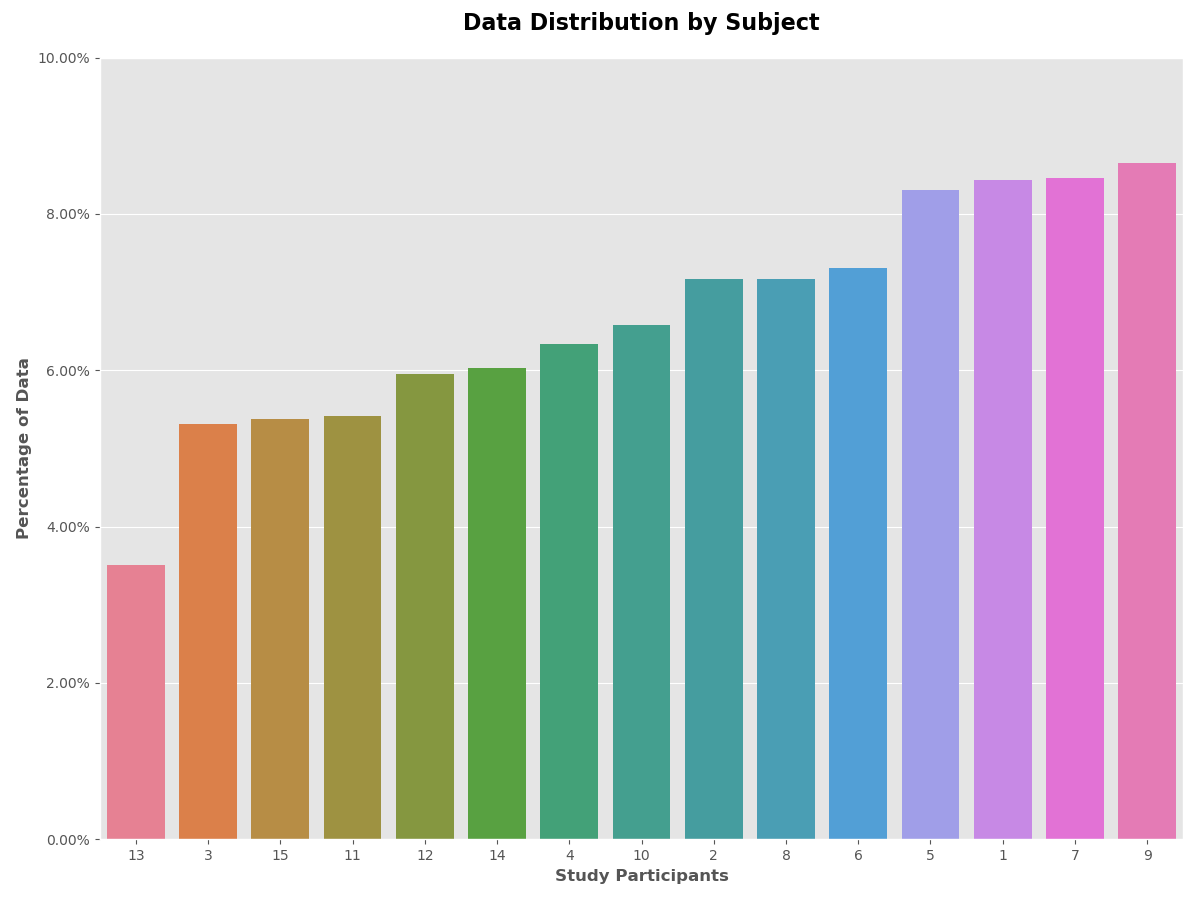

In [49]:
from IPython.display import Image
Image(filename='images/SubjectDistribution.png')

##### Distribution by Activity

Unfortunately, the distribution of data relative to activity type is heavily skewed, as one can see below.

The first three activites only account for about 2.5% of the data each. Compounding that, *Talking while Standing* and *Working at Computer* dominate the distribution, each coming in at over 30%. The heavily skewed nature of the target distribution will be problematic during the modeling process, and an explanation regarding why will be given later on, after looking a little closer at the data we have, and once we are closer to modeling.

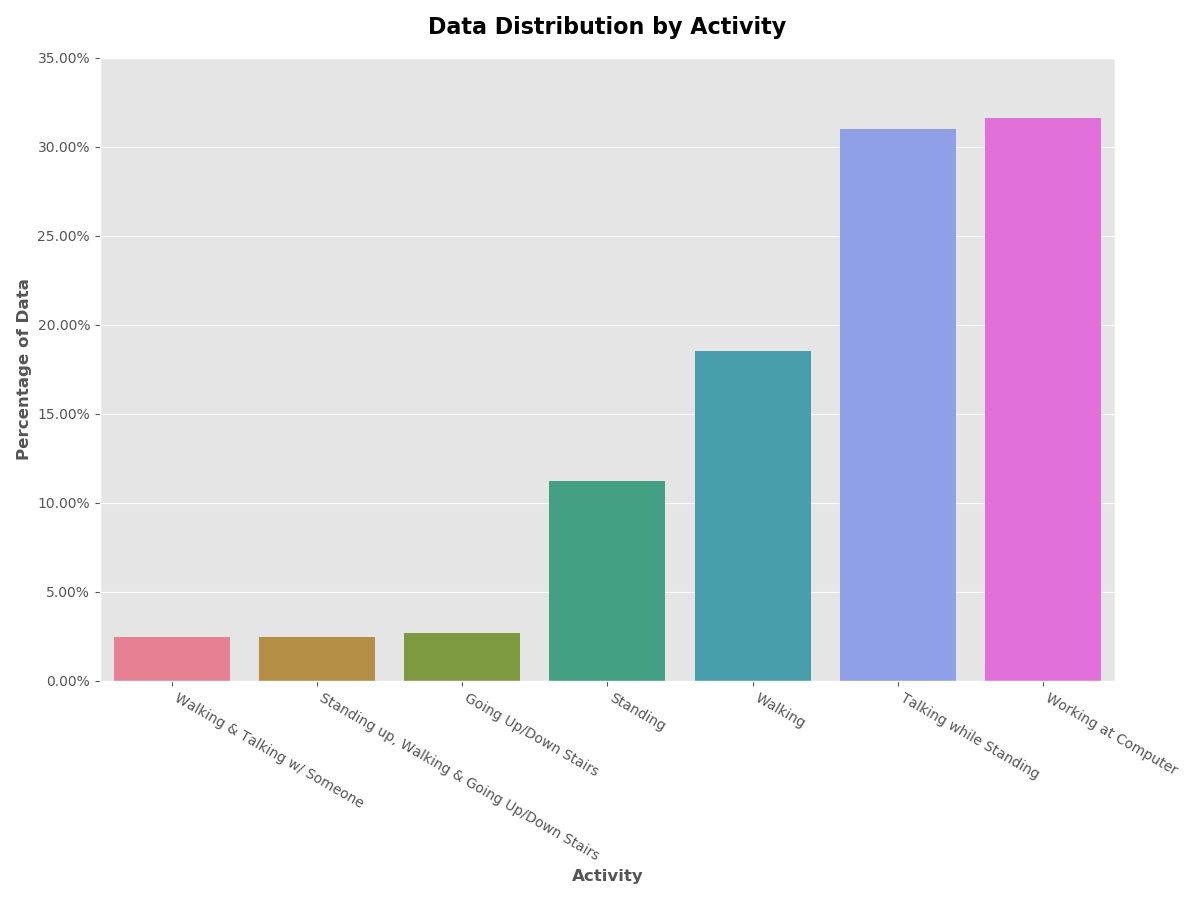

In [50]:
# distribution of activities
Image(filename='images/InititalActivityDistribution.png')

#### A look at the Data

Looking at the table of summary statistics below, a question that will pop up (if it hasn't already) is, "What do these numbers mean?"

In [51]:
df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std])

mean               \
                                                   x_acc        y_acc   
label                                                                   
Going Up/Down Stairs                         2000.554449  2385.493844   
Standing                                     1996.272755  2378.303095   
Standing up, Walking & Going Up/Down Stairs  1969.489431  2371.051965   
Talking while Standing                       1998.340516  2389.217249   
Walking                                      1976.819111  2386.292905   
Walking & Talking w/ Someone                 2027.107076  2374.075277   
Working at Computer                          1977.689653  2376.558532   

                                                                 std  \
                                                   z_acc       x_acc   
label                                                                  
Going Up/Down Stairs                         1997.001573  111.237068   
Standing                                     1965.729391  121.542182   
Standing up, Walking & Going Up/Down Stairs  1940.448703  110.537379   
Talking while Standing                       1973.384663  105.939770   
Walking                                      1978.708646  124.060266   
Walking & Talking w/ Someone                 1952.189366  121.550283   
Working at Computer                          1966.415593  101.580145   

                                                                     
                                                  y_acc       z_acc  
label                                                                
Going Up/Down Stairs                         107.876324   91.282547  
Standing                                      89.361650   70.465477  
Standing up, Walking & Going Up/Down Stairs   87.912346  108.297306  
Talking while Standing                        95.753926   63.859416  
Walking                                      114.916367   90.972573  
Walking & Talking w/ Someone                  87.496785   76.124904  
Working at Computer                           99.827210  123.734287

According to [this website](https://learn.sparkfun.com/tutorials/accelerometer-basics/all), "[Accelerometers] measure in meters per second squared $\left( \frac{meters}{second} \right)^2$, or in G-forces (g, where 1 g = 9.8 $\left( \frac{meters}{second} \right)^2$)" (at least on this planet, but we don't need to get into that...)

In addition to these units not being overly intuitive for most people, the actual values aren't of great concern for modeling. By standardizing each of the three dimensions (mean = 0,  variance = 1), the units will become "standard deviations from the (overall) mean"

In [52]:
dtype_dict = {'seq':object,
              'x_acc':float,
              'y_acc':float,
              'z_acc':float,
              'label':object,
              'subject':object}

# check src/format_data.py for aggregate_subjects() function
scaled_df = standardize_df(df, ['x_acc','y_acc','z_acc'], ['seq','label','subject'], dtype_dict)

After the data has been standardized, the same table as above can be interpretted more intuitively.

For example, you'll notice that the mean for "Going Up/Down Stairs" in the Z dimension is the highest out of any of the activities. This means that, although the *overall* mean for the Z dimension is 0, a relatively high value (close to 0.3) would suggest that the activity being performed is more likely to be "Going Up/Down Stairs."

In [53]:
scaled_df.pivot_table(index=['label'], values=['x_acc','y_acc','z_acc'], aggfunc=[np.mean, np.std])

mean                      \
                                                x_acc     y_acc     z_acc   
label                                                                       
Going Up/Down Stairs                         0.115863  0.029617  0.279544   
Standing                                     0.077413 -0.042065 -0.051522   
Standing up, Walking & Going Up/Down Stairs -0.163103 -0.114349 -0.319159   
Talking while Standing                       0.095982  0.066734  0.029521   
Walking                                     -0.097282  0.037582  0.085884   
Walking & Talking w/ Someone                 0.354308 -0.084210 -0.194865   
Working at Computer                         -0.089464 -0.059456 -0.044258   

                                                  std                      
                                                x_acc     y_acc     z_acc  
label                                                                      
Going Up/Down Stairs                         0.998916  1.075375  0.966373  
Standing                                     1.091457  0.890810  0.745991  
Standing up, Walking & Going Up/Down Stairs  0.992633  0.876362  1.146502  
Talking while Standing                       0.951346  0.954532  0.676055  
Walking                                      1.114069  1.145554  0.963092  
Walking & Talking w/ Someone                 1.091529  0.872220  0.805905  
Working at Computer                          0.912196  0.995137  1.309927

#### Outlier Detection

In a non-sequential data set, outliers are (typically) defined by their distance from the main cluster of datapoints. In this data set, the definition of "outlier" is going to be defined as a **behavioural** outlier - a study participant that behaves differently from all the others for a given activity that could bias our model.

The plot below shows the standardized X-axis acceleration for each participant. Looking closely at *Participant 12*, one will notice that while most of the other participants have very little x axis acceleration while working at their computer, *Participant 12's* measurements seems to jump around quite frequently.

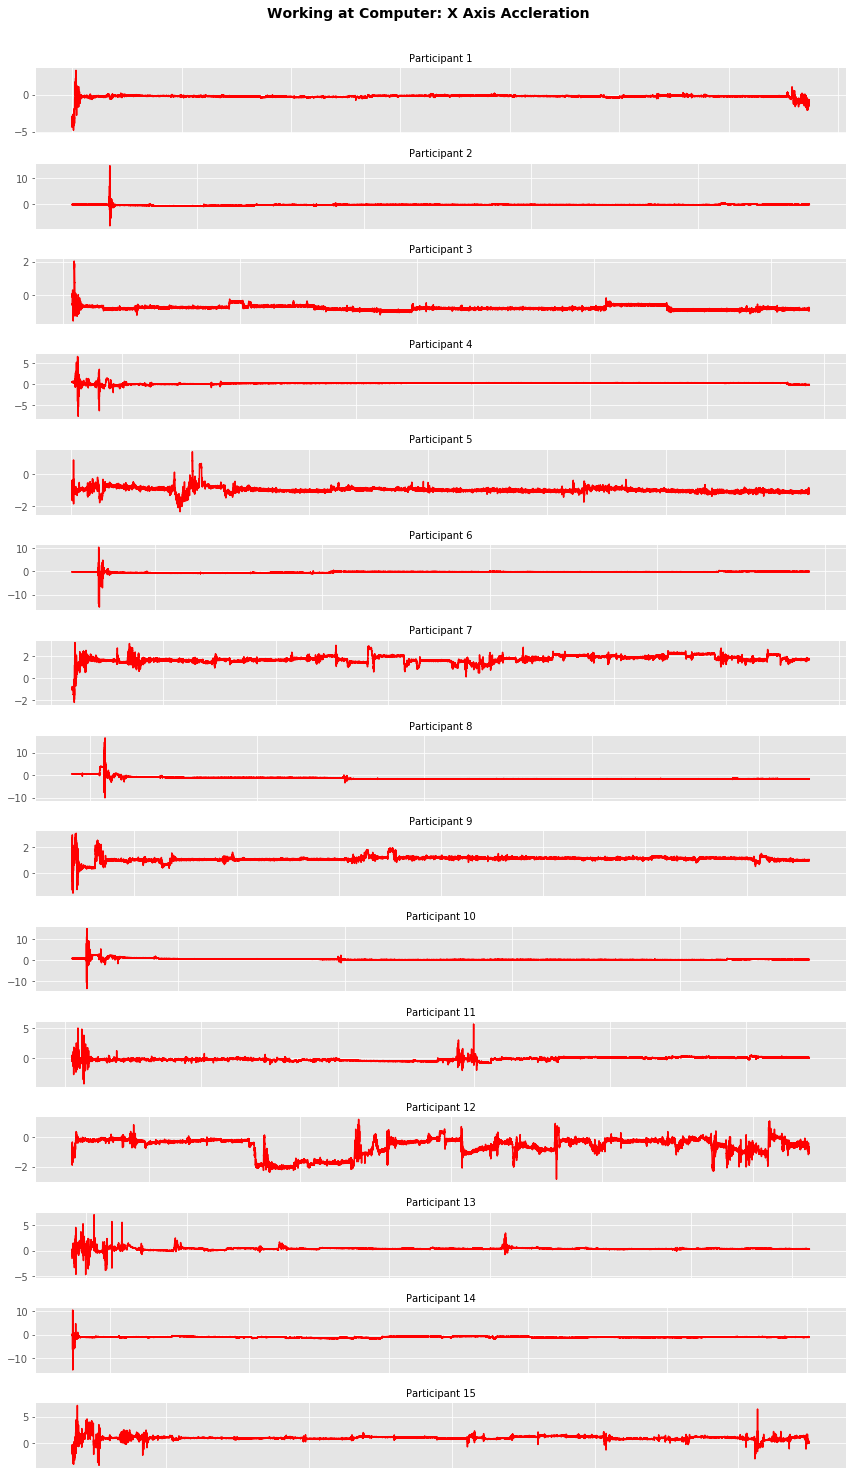

In [89]:
display_df = scaled_df[scaled_df['label'] == 'Working at Computer']

# check plotting.py for subject_comparison_plot()
from src.plotting import *
subject_comparison_plot(display_df, 'x_acc', 'red', 'Working at Computer: X Axis Accleration')

#### How do the Movement Patterns Differ?

Since the end goal is to identify a particular activity based on the various dimension measurements, looking at how these measurements differ across time will show what the various models will be able to use to differentiate between activities. For the sake of demonstration, the first subject will be used as an example.

In [77]:
display_df = scaled_df[scaled_df['subject'] == '1']

The plots below show the behaviour of the different activities in sequential order, for each dimension. Although there are some similarities between the different activites, there are some movements that can be thought of quite intuitively.

For example, one will notice that *Walking* has a consistently dense variation around its mean in each dimension. This makes intuitive sense in that, while walking, there is going to be some consistent upward and downward oscillation as the subjects rolls off the ball of their foot with each step. In addition, the slight swinging of the arms will rotate the shoulders slightly, which in turn will ever so slightly move the chest (where the accelerometer is located).

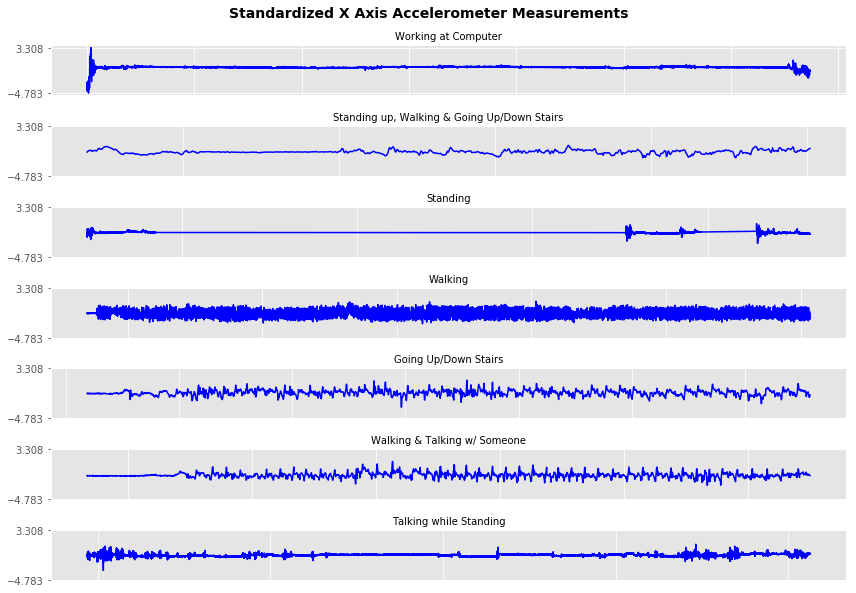

In [78]:
y_range = [np.min(display_df.x_acc), np.max(display_df.x_acc)]
dimension_plot(display_df, 'x_acc', y_range, 'blue', 'Standardized X Axis Accelerometer Measurements')

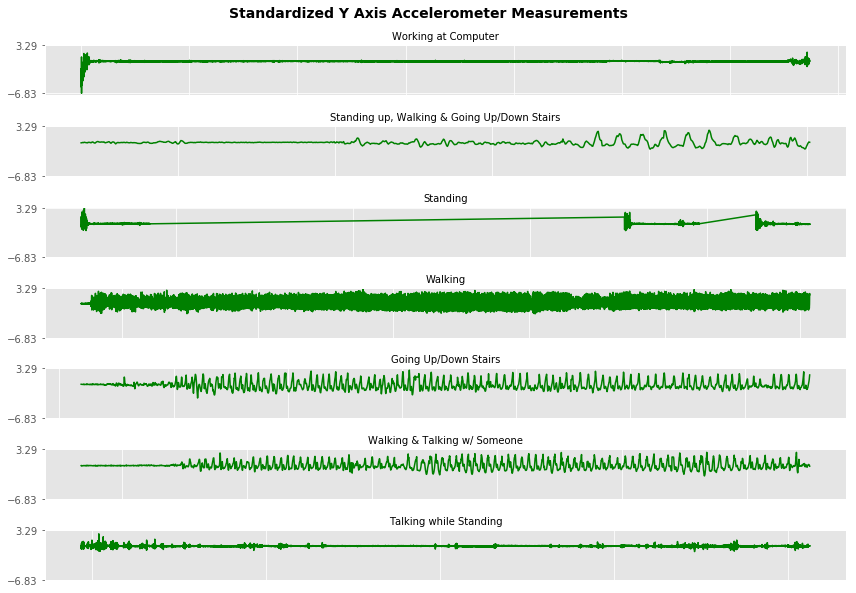

In [71]:
y_range = [np.min(display_df.y_acc), np.max(display_df.y_acc)]
dimension_plot(display_df, 'y_acc', y_range, 'green', 'Standardized Y Axis Accelerometer Measurements')

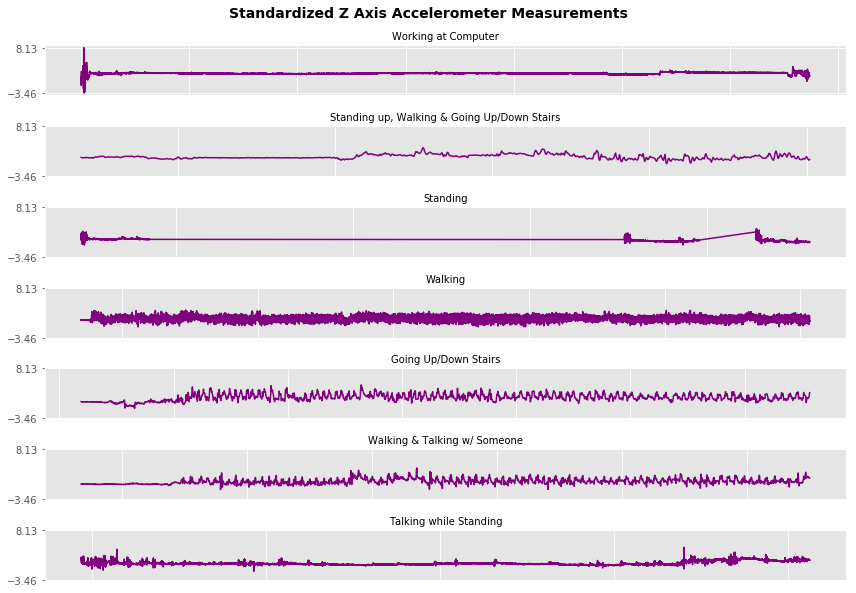

In [72]:
y_range = [np.min(display_df.z_acc), np.max(display_df.z_acc)]
dimension_plot(display_df, 'z_acc', y_range, 'purple', 'Standardized Z Axis Accelerometer Measurements')

### Modeling

As eluded to by the, "3 Different Approaches" part of the title, there is more than one way to approach the modeling process. The three approaches that will be looked at are as follows.

#### The "Traditional" Approach

* This is how the modeling process is typically approached in data science and is how the data has been treated thus far. Using this approach, all 15 study participants are concatenated into one large data set and a traditional train test split determines which observations are trained and tested on.
    
* This approach can be thought of (roughly) as answering the question, "Which model is best at learning a population's movement pattern?"
    
* One **glaring drawback** of this approach is the testing set consists of instances of a behavioral pattern that was used to train the model. In other words, the model isn't being tested on identifying unseen behavior patterns - it is only being tested on identifying *unseen instances of a known behavior pattern.*

#### The "Generalizable" Approach

* This approach attempts to address the above drawback. This approach will train on n - 1 subjects (14 in this case) and be tested on the $n^{th}$ subject, and can be thought of (roughly) as answering, "Which model is best at generalizaing to unseen subjects?"
    
* Although not necessarily a drawback, one thing to keep in mind with this approach is it's intrinsic difficulty; as shown in the *Outlier Detection* section, people move very differently. This approach does assume there is some consistent, underlying pattern across all subjects.


#### The "Individual" Approach

* Finally, the "Individual" approach will split each subject into a training and testing set, and see which model is best at learning that individual's behavior. This can be thought of (roughly) as answering the question, "Which model is best at learning and individuals movement pattern?"

Prior to any modeling, however, the evaluation metric by which the various models that are tested will be assessed should be defined, with clear reasoning.

##### Evaluation Metrics

There a few different metrics one could use for a classification problem, the most common being Precision, Recall or Accuracy. Precision seeks to minimize false positives and Recall seeks to minimize false negatives, while Accuracy takes a more balanced approach. Accuracy will be used as the evaluation metric, however *why* this will be used as the evaluation metric deserves a short explanation.

Although this data set has seven possible classifications, an explanation using a ficticious dichotomous decision process will drive the point home more directly.

A classic example of a process like this is medical testing. Imagine a test that tests the patient for cancer. If the patient tests positive (i.e. the test says they have cancer), they go on to the next step in the diagnosis process which is an additional $1,000 test. If the patient tests negative (the test says they don't have cancer), they are released and are able to continue with their lives.

It is clear that there are two ways the testing process can be wrong in this situation:

1. The test says they **do** have cancer when they in fact do not. This is called a False Positive. (FP for short)
2. The test says they **do not** have cancer when they in fact do. This is called a False Negative. (FN for short)

When deciding what evaluation metric to optimize for, one must take into account the costs of being wrong. In the above scenario, the cost of a FP is \\$1,000 and the time and inconvenience of an additional test to the patient who does not in fact have cancer. On the other hand, the cost of a FN is telling the patient they are okay when in reality they should start treatment immediately. The latter is clearly the worse of the two options; a patient that doesn't know they have cancer runs the risk of the cancer metastasizing, which would not only cause their medical bills to be much higher than \\$1,000 in the future, but would also increase their chance of death.

In this situation, one should be willing to sacrifice at least a couple FP's to save one FN, and would therefore choose Recall as the performance metric.

Coming back to the problem at hand, there are seven different possible classifications. This means there are six ways to be *wrong* for each class. With seven classes, that comes out to **42 different ways to be wrong, and only seven ways to be right**. Since there is no clear evaluation of the costs of being wrong (as there are in the example above), I will be treating each incorrect prediction the same, and therefore using accuracy as my evaluation metric. That is, misclassifying an observation as *Walking*, when it is actually *Standing*, will be treated the same as misclassifying an observation as *Walking & Talking w/ Someone*, when it is actually *Working at Computer*.

##### Feature Engineering: Bringing in the Sequential Nature of the Data

Since this problem has a sequential aspect to it, I am going to create a few new features that effectively allow the model to "look back" at previous acceleration measurements.

One of the main questions that needs to be addressed with regard to any sequential model is:

* Should the model have access to the previous state of the subject?

Another way of phrasing this is; do we want our model to be able to use the activity the subject was performing "a moment ago" to predict the activity the subject is currently performing?

While many sequential modeling frameworks take advantage of this, I am going to assume that the only sequential aspect of the data that we would like to preserve is the accelerometer's measurements in each dimension (and any features that can be derived from these). There are a couple reasons for this:

1. The training data was presented in a very specific manner; that is, the activities were ordered as they are written at the beginning of this report (i.e. in each file, all the observations for *Working at Computer* were at the beginning of the file and immediately followed by all the observations for *Standing up, Walking and Going Up/Down Stairs*, etc.) I am assuming this purely due to the design of the experiment. In the real world, people don't follow a monotonous routine of repeating the same pattern of movements over and over again, and we would ideally like to build a model that can predict a subjects activity even if they don't perform the activities in the same order as the training data.


2. If I were to give the model access to the previous state of the subject, the modeling process would become arbitrarily easy in the sense that a highly accurate model would be to just predict the previous activity state as the current activity state. This is tangential to the problem outlined in point one - the design of the experiment had each subject perform one activity after another. A natural thought then becomes, "Just shuffle the data and this problem evaporates". Unfortunately, shuffling the data would compromise the sequential nature of the accelerometer measurements, which we know we want to take advantage of.

In order to allow our model to be able to view the sequential nature of the data set without shuffling the data, I am going to introduce new variables that allow the model to look back in time, while still preserving the independence of the observations.

An illustration of what is happening is shown below.

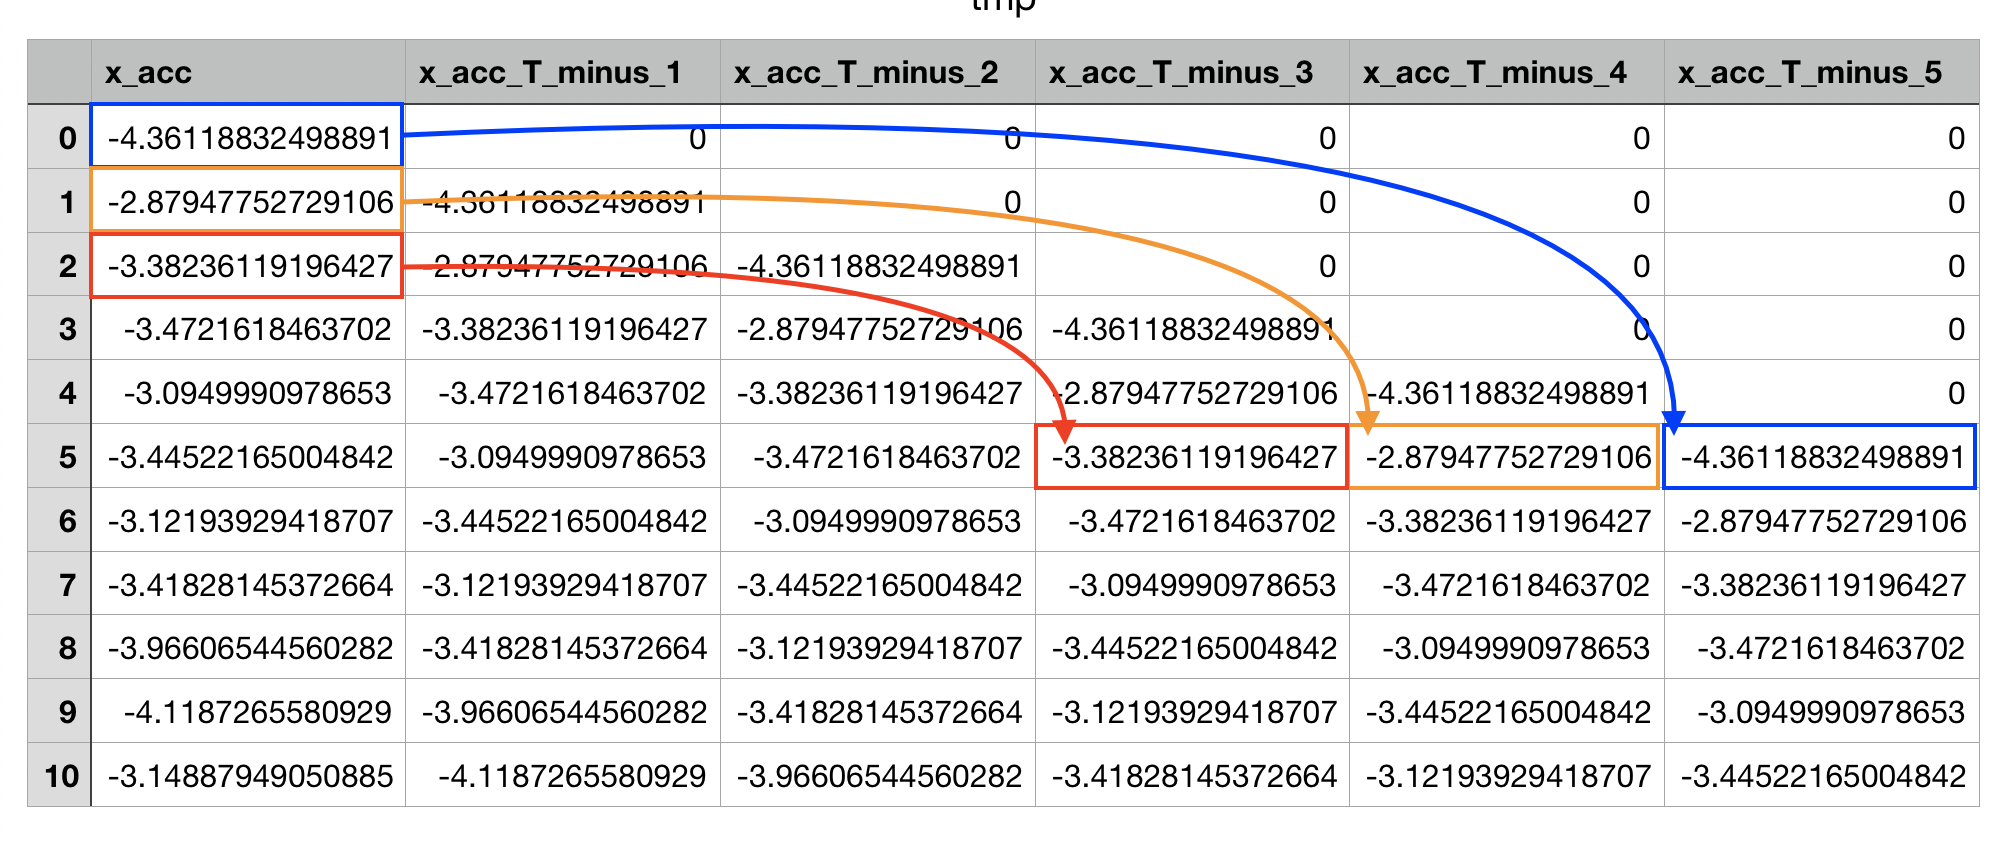

In [86]:
Image(filename='images/timelag_illustration.png')

As shown above, this process necessarily imputes some 0's into the datat set. Any observations with 0 were dropped prior to modeling (the number dropped depends on the approach taken, and will be mentioned in the appropriate section).

##### Models Tested

After creating the lagged variables mentioned above, fitting a variety of models to the data set will show which model is the best for the given approach. The models that were tested were:

1. Random Forest (comprised of 500 decision trees).
2. Multi Layer Perceptron (two hidden layers of 100 neurons each).
3. AdaBoost Classifier (500 decision "stumps", only allowed to make one split).
4. Gradient Boosting Classifier (500 decision "stumps", only allowed to make one split).
4. Multinomial Logistic Regression (using "One-vs-Rest" methodology, which fits a binary problem for each class).

In order to take advantage of standardizing the training data, each of these models were put into a `Pipeline()` object that started with a `StandardScaler()` object. Modeling in this manner allows the `Pipeline()` object to be used in cross validation, ensuring that the training data is standardized and used to fit the model, while the testing data is transformed using the training data values. An example of one of the pipelines is shown below.

```python
rf_pipeline = Pipeline([
   ('scaler', StandardScaler()),
   ('model', RandomForestClassifier(n_estimators=500,
                                    random_state=5,
                                    n_jobs=-1,
                                    verbose=1))
])
```

#### Undersampling Rationale

As mentioned in the **Data Distribution by Activity** section, the skewed distribution of the activity can pose some problems in the modeling process.

The reason an unbalanced data set can be problematic when optimizing a model with respect to accuracy is most clearly illustrated in a binary setting, illustrated in the plot below.

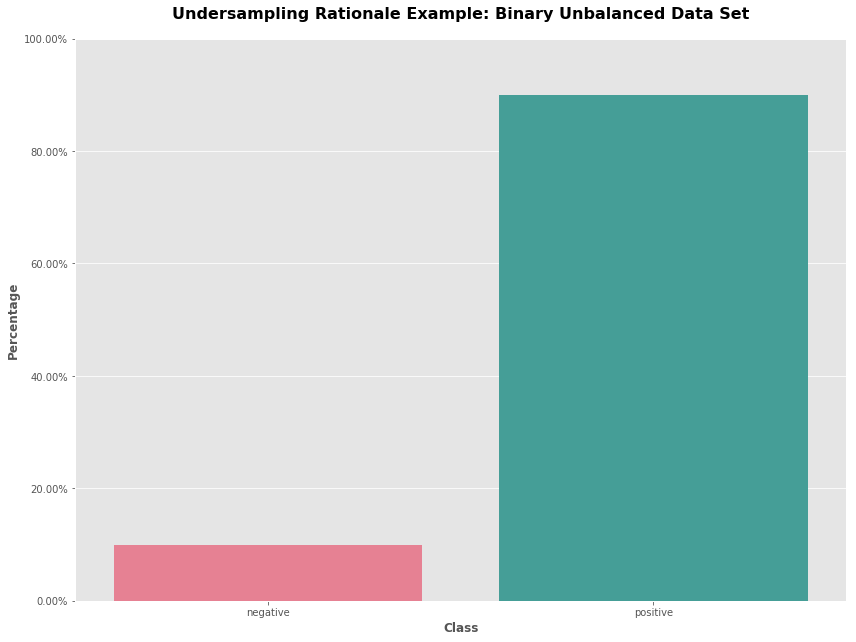

In [102]:
barplot(pd.DataFrame({'percentage': [0.1, 0.9], 'class': ['negative','positive']}),
        values_col='percentage',
        labels_col='class',
        x_label='Class',
        y_label='Percentage',
        title='Undersampling Rationale Example: Binary Unbalanced Data Set')

With a binary data set that is skewed in this manner, one could classify every observation as positive and achieve 90% accuracy. Since the equation for accuracy is the number of correctly classified over all possible classifications:

$$
Accuracy = \frac{TP + \mathbf{TN}}{TP + \mathbf{FP} + TN + FN}
$$

If the above plot was illustrating the distribution of a data set with 100 observations, achieving 100% accuracy would result in correctly classifying all of the positive and negative observations. That is:

$$
Accuracy = \frac{90 + \mathbf{10}}{90 + \mathbf{0} + 10 + 0} = 1 = 100\%
$$

However, by accepting the hit of 10 false positive's, a 90% accuracy can be easily reached with a "model" that doesn't look at any inputs, and purely manipulates the target distribution to it's advantage.

$$
Accuracy = \frac{90 + \mathbf{0}}{90 + \mathbf{10} + 0 + 0} = 0.9 = 90\%
$$

So, in order to stymie this in the problem at hand, [Random Undersampling](https://imbalanced-learn.readthedocs.io/en/stable/generated/imblearn.under_sampling.RandomUnderSampler.html#imblearn.under_sampling.RandomUnderSampler) was employeed in order to adjust the target distribution. This process randomly drops instances of the majority classes in order to bring the target distribution to that which resembles a discrete uniform distribution. After this was performed, the data distribution with respect to the activity is shown below.

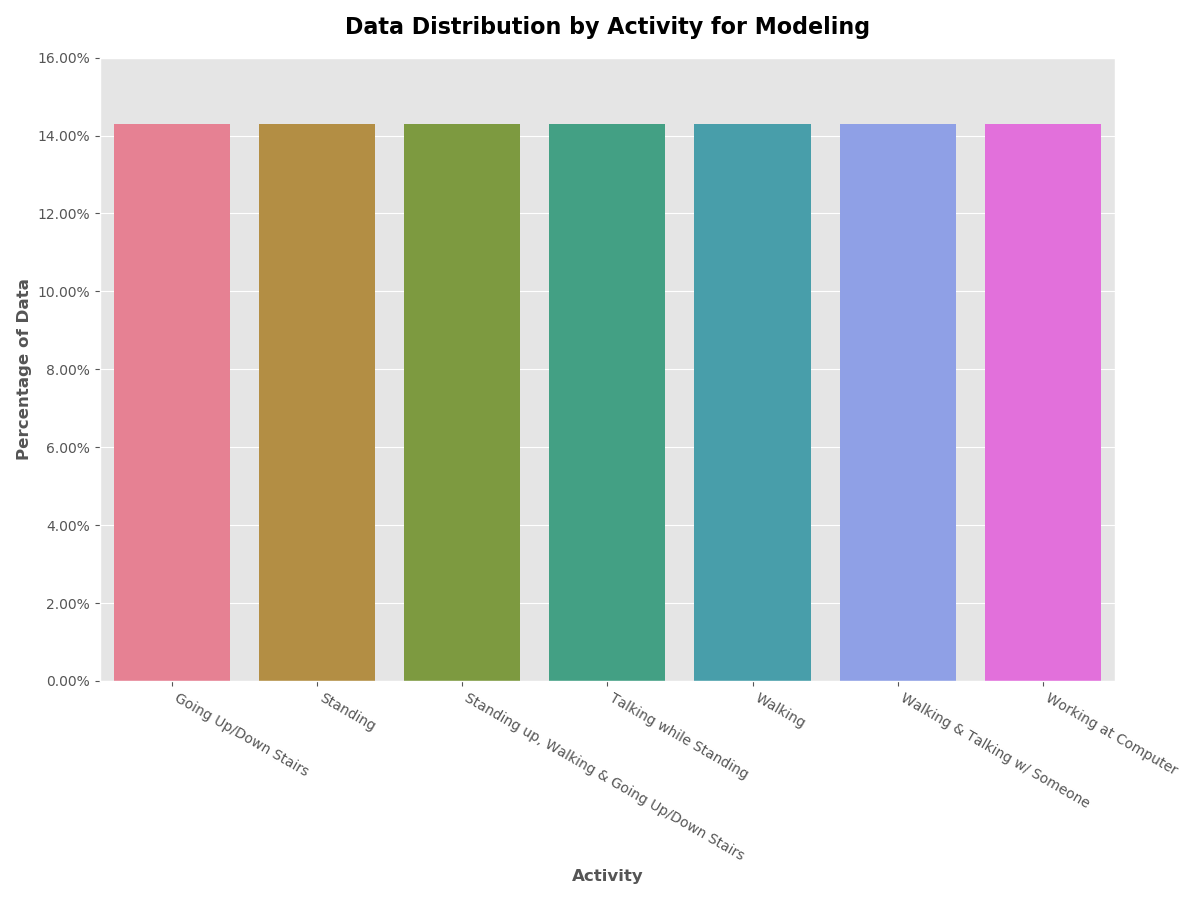

In [87]:
Image(filename='images/ModelingActivityDistribution.png')

#### The "Traditional" Approach

After all the above was performed, the various models showed the below results. Eight fold cross validation was performed on **two** data sets:

* 5 Step Time Lag Data Set

    This data set contained lagged variables (mentioned above) that "looked back" five sequence steps. In creating these variables, 

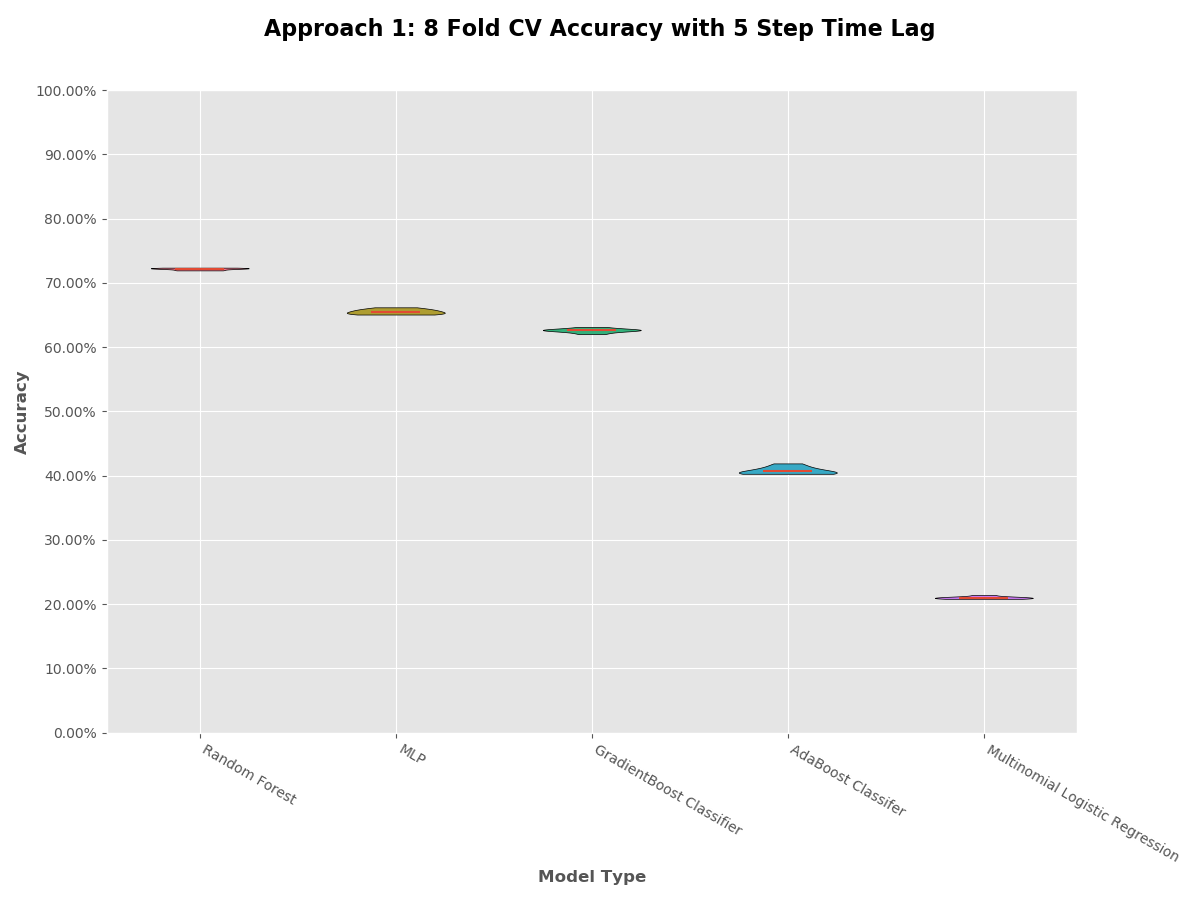

In [105]:
Image(filename='approach_1/images/Approach1_InitialCV_Lag5.png')

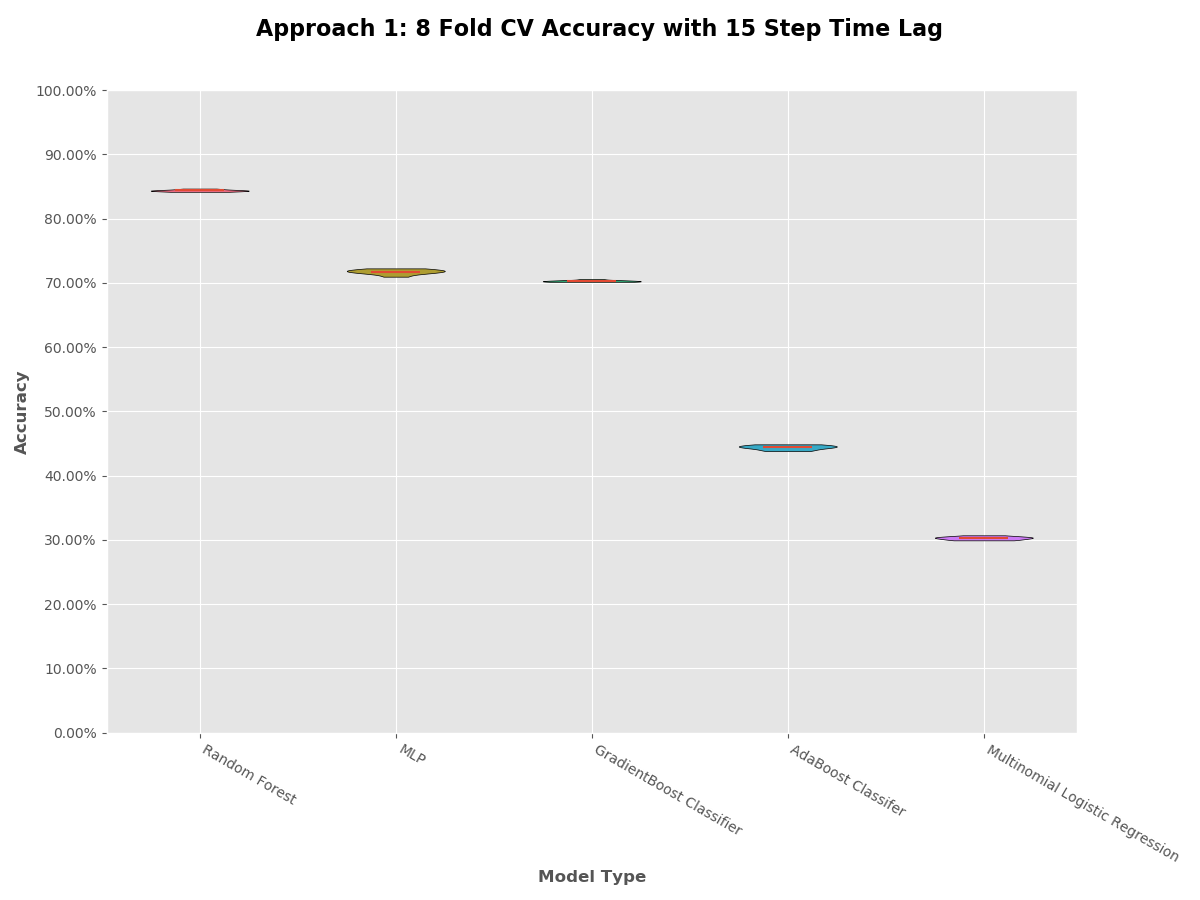

In [106]:
Image(filename='approach_1/images/Approach1_InitialCV_Lag15.png')

In [83]:
from IPython.display import HTML, display
display(HTML("<table><tr><td><img src='approach_1/images/Approach1_InitialCV_Lag5.png'></td><td><img src='approach_1/images/Approach1_InitialCV_Lag15.png'></td></tr></table>"))

,


###### Defining a Benchmark Model

Although this data is inherently sequential, it is worth seeing what sort of accuracy can be acheived with a simple model; if a complex model barely outperforms a simple model, the simpler model will likely come out ahead in the long run due to the being more generalizable (bias-variance trade off).

The base model will be a Random Forest, which is a statistical learning method that, as the name hints at, is a collection of Decision Trees that has the nice property of rarely overfitting.





###### Technical Explanation of Random Forests

Now that the the evaluation metric has been outlined, a short explanation of the Random Forest algorithm is in order prior to fitting our model to the data.

###### Decision Trees

To fully explain what a Random Forest is, one must first start with the definition of a decision tree. A decision tree is a statistical learning algorithm that recursively splits the data set into two subsets, the (idealistic) goal of each split being to move towards having a "pure" leaf, which is defined as a region where only one class is present. In the image below, the square at the bottom right of the diagram, with the only activity being *Standing*, would be considered a "pure" leaf (i.e. hypothetically, all observations that have an scaled *x_acc* value greater than 0 and a scaled z_acc value greater than -0.035 are *Standing* observations)

This process of repeatedly splitting a set into two non-overlapping subsets is repeated on each of the two subsets, then again on both of those subset's subsets, and so on. The image below provides a good visual of how this occurs.

In [ ]:
Image(filename='images/decision_tree_diagram.png')

###### Bagging (A Group of Decision Trees)

Now, imagine 50 decision tree's built on bootstrapped data sets (a "bootstrapped" data set is a simulated data set that is created by randomly drawing observations from our sample until we have a new data set that is the same size as the original. Every time an observation is drawn, it is replaced into the conceptual bag from which observations can be drawn). Each decision tree follows the same recursive binary splitting algorithm outline above, however since each individual tree is being trained on a slightly different data set, details of each tree will vary.

To determine what activity an unseen observation will be classified as, it is "dropped down" each of the 50 decision trees, resulting in 50 (potentially different) classifications. Once this is completed, the most frequently predicted activity (out of the 50) is designated as the final prediction.

###### Random Forests

Finally, we get to Random Forests. Random Forests are almost identical to Bagging, with one minor difference; with Bagging, whenever a splitting decision has to be made, the algorithm has access to all the variables to determine the best split value possible. With a Random Forest, whenever a splitting decision has to be made, the algorithm *only has access to a subset of the variables from which it can select a split value*.

Although somewhat counter-intuitive, the intuition behind this is, by decorrelating the trees in a forest, the overall *ensemble* is able to generalize better to new, previously unseen data (trading a little increase in the bias of the model for a, hopefully larger, decrease in the variance).

#### Benchmark Model

Below is the cross validated accuracy for our benchmark model - a Random Forest with 500 trees.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

random_forest = RandomForestClassifier(n_estimators=500, random_state=5)

# check format_data.py for base_estimator_X and base_estimator_y
random_forest_scores = cross_val_score(random_forest,
                                       base_estimator_X,
                                       base_estimator_y,
                                       cv=8,
                                       scoring='accuracy')

print('Average Accuracy | {:.2%}'.format(random_forest_scores.mean()))
print('Accuracy Std. Dev. | {:.2%}'.format(random_forest_scores.std()))

Although the average accuracy isn't horrible considering random guessing with 7 classes is around 14%, the standard deviation of those scores is somewhat troubling. Moving forward, these will be the numbers to beat.

Previously, we looked at how the movement pattern's means and variances differed across the entire data set, both stagnant statistics. In order to beat our benchmark model, taking a closer look at the sequential nature of the data will likely need to occur.

As you can see in the image, this process necessarily imputes some zeros into the start of each activity dataframe. However, since there are only 7 activities and we are only creating a lag of 5 steps, dropping these observations will not be huge cost to the amount of data we have (7 x 5 = 35 observations removed).

In addition to adding the lag, I will create a "rolling average" over the previous 5 timesteps for each dimension. This will give our data an additional attribute that will give each step the average of itself and the last 5 steps in each dimension.

# EDIT THIS SECTION

##### A Note on Data Limitations

It is important to note that although the absolute quantity of observations this data set contains is quite high (roughly 2 million), there were only *15* people from whom measurements were taken (14 in the training data set).

In the grand scheme of things, this is relatively small sample. Since we are working with accelerometer data, we should keep in mind that a person's physical body size plays a role in how their body moves. For example, if all 14 applicants were smaller people, the model might not generalize well to larger individuals. Since there isn't any information on this in the problem description, there is no way to tell whether this variation has been captured by who ever designed this experiment. One would have to keep this in mind if the experiment were to be redesigned.


Again, if there were more participants in this study who showed behaviour closer to that of the "normal" participants, I might consider removing participant 12 altogether. However, due to the small sample size (referring to the number of participants in the study) and the naturally high ambiguity of the problem (as I mentioned above, people move very differently), I will move forward with a 'mental grain of salt' with regard to participant 12.

In [ ]:
# setting seed for reproducibility
np.random.seed(5)

# check modeling.py for cross validation of multiple models.
# note that this cell is going to take a while...see the 'Training Time Complexity with GridSearchCV' section (below)
%run -i 'modeling.py'

The violinplot below shows both the Random Forest and Multi Layer Perceptron hovering just below 90% (The values are printed below the plot).

In [ ]:
cv_error_comparison_plot(pd.DataFrame(cv_error_dict),
                         x_label="Model Type",
                         y_label="Accuracy",
                         title='8 Fold Cross Validation Accuracy',
                         long_x_names=True,
                         filename='../images/15_subject_cv_model_comparison.png')

print('Random Forest Average Accuracy | {:.2%}'.format(model_dict['Random Forest']['CV Scores'].mean()))
print('MLP Average Accuracy | {:.2%}'.format(model_dict['MLP']['CV Scores'].mean()))
print("\n")
print('Random Forest Accuracy Std. Dev. | {:.2%}'.format(model_dict['Random Forest']['CV Scores'].std()))
print('MLP Accuracy Std. Dev. | {:.2%}'.format(model_dict['MLP']['CV Scores'].std()))

As shown above, there is a significant increase in the prediction accuracy after introducing the lagged variables.

Since the Random Forest and the Multi Layer Perceptron are neck and neck in the race for the lead model, I will use the Random Forest moving forward since it is a much simpler model, takes less time and computational resources to train, and has the added benefit of being (more) easily interpretable. This last point brings us to graph below, the Feature Importances.

In [ ]:
plot_feature_importances(feat_imp_df,
                         'Importances',
                         'Variable Names',
                         "Relative Importance (higher = better)",
                         "Variable Names",
                         "Feature Importances")

#### Feature Importance Guided Feature Engineering

The plot above shows the "Feature Importances" of the Random Forest. A feature's importance is measured as the mean decrease in the impurity measure (Gini Impurity, in this case), averaged across all trees in the forest (on top of the traditional averaging over all splits in a single tree). In other words, a feature's relative importance is how useful that feature was in increasing the purity of nodes across all tree's in the forest.

Although no variable is *vastly* more "important" than any other, one will notice that the rolling average variables, along with the greater time-lagged variables, are in the upper half of the plot, indicating they were more useful in the decision process that is emobodied by the Random Forest.

With the information in mind, I'm going to increase the the time lag to 15 steps, and create three rolling averages: one that looks 5 time steps back (as we had before), one that looks 10 time steps back, and finally one that looks 15 time steps back. In addition to the three rolling averages, three rolling variances will be created as well (same time lag as the averages). Finally, in an effor to reduce unnecessary dimensionality increases, I will drop any attributes whose time lag can't be evenly divided by 5. This leaves the below variables on which the Random Forest can be fine tuned:

In [ ]:
print(lag_15_df.columns)

#### Fine Tuning with GridSearchCV

In addition to giving the model more attributes to model off of, grid searching over a portion of the possible parameter space will allow us to find the best parameters for the model.

The RandomForestClassifier has various parameters to tune, of which I will try the following options:

1. Parameter | `n_estimators` - Values | `[250, 500, 1000, 1500]`

    * Number of trees in the forest - random forest's typically don't overfit, so it is safe to try a large number of individual estimators without risking overfitting. That said, if 500 trees is almost as good as 5000 trees, the reduction in model complexity might be worth reverting to the 500 tree model.


2. Parameter | `max_features` - Values | `['sqrt','log2', None]`

    * As mentioned above, the defining charactertistic of a Random Forest is that it is only allowed to view a random subset of the variables as split candidates at each internal node. The `max_features` parameter defines the number of random features that can be considered at each split. `sqrt` is the standard, and is the square root of the total features in the data set. `log2` is the log base 2 of the number of features in the data set, and `None` gives the algorithm access to all features at each split (this would be the'Bagging' algorithm with Decision Tree's as the base estimator, mentioned above).


3. Parameter | `class_weight` - Values | `['balanced', None]`

    * In the **Data Distribution by Activity** section at the start of the report, I mentioned that training a model with accuracy as the evaluation metric can be problematic with an unbalanced data set. The reason for this is that under-represented classes can be 'thrown to the wayside' in favor of building a model that more accurately predicts the over-represented classes.
    
    For example, imagine a game where there is a bag of marbles and the goal is to be able to identify a marble's color (blue or red) based on its size, shape (pretend some marbles aren't spheres) and texture. In this bag, there are 100 total marbles; 90 red and 10 blue. Someone playing this games could achieve 90% accuracy, without even opening the bag, by just calling all marbles red (90 correct classifications - calling all the red marbles red, and 10 incorrect classifications - calling all the blue marbles red. 90 / (90 + 10) = 90%).
    
    Coming back to the problem at hand, under-represented classes may not be predicted at all with an unbalanced data set. The class_weight parameter allows one to specify the `balanced` option, which weights instances of underrepresentced classes so that they are given equal priority in the model-building process (in other words, they won't be 'thrown to the wayside'). The `None` option leaves the data set as it is - unbalanced.
    
##### Training Time Complexity with GridSearchCV

Since there are 3 parameters over which I'm searching for the best of 4, 3 and 2 options, there will be a total of 24 different models that will be tested. In addition, by using cross validation with 8 folds, this comes to a total of $24~x~8~=~\mathbf{192}$ times that the `fit()` and `predict()` methods will be called. On a data set of this size, this will clearly take some time.

In [ ]:
cols = [i for i in grid_search_results_df.columns if i.endswith('_test_score') and i.startswith('split')]

In [ ]:
grid_search_results_df[cols].T.plot()

### Conclusion

As shown below, our final model does very well on unseen data. The below is a multi-class confusion matrix displaying the final model's test set predictions against the actual test set labels. A perfect score would be a diagonal matrix, where all numbers except those along the diagonal are zero.

Even with the disproportionate class sizes, the model did a good job of classifying the observations with low representation in the data st (i.e. the activity *Standing up, Walking & Going Up/Down Stairs* had relatively low representation in the data set (roughly 170 observations in the training set and 60 in the testing set), however the model perfectly classified all these instances.

In [ ]:
# scaling the test data using the training data values
X_test_scaled = scaler.transform(X_test)
y_hat = random_forest1.predict(X_test_scaled)

pd.DataFrame(data=confusion_matrix(y_test, y_hat), columns=random_forest1.classes_, index=random_forest1.classes_)

In [ ]:
correct = np.where(y_test == y_hat, 1, 0)
print("Testing Data Set Overall Accuracy | {:.2%}".format(np.mean(correct)))

In [ ]:
proportion = averager.aggregated_df.groupby('label').count()['seq'] / averager.aggregated_df.shape[0]
proportion.sort_values(inplace=True)

bar_plot(proportion.index, proportion, 'green', 'Activity', 'Percentage of Data','Activity Distribution', True)

### Next Steps

There are a few ways in which this analysis/model could be improved:

##### Model Improvements
* Increase the lag, allowing the model to look further back in time.
    * Since introducing the lagged variables, as well as the rolling average significantly increased the accuracy, it would be worth experimenting with how far back we allow the data to look
    * One of the downsides of increasing the lag is, if this model were to go into production, data would have to be cached for the same amount of the lag before the model could make a prediction.
* Test various model architectures, including those that are specifically designed for sequential data, such as an RNN or LSTM. Pit all of these models againsts each other and see which comes out on top.

##### Data Improvements
* Although the model performed relatively well on classifying each class, the uneven distribution of classes in the data set could be remedied by a sampling technique such as T-Distributed Stochastic Neighbor Embedding (t-SNE) or simply running the experiment for a longer period of time (accelerometers are not overly expensive and finding subjects to wear one for a day shouldn't be too difficult).

* In the ActivitySequenceAverager class, I am using an *inner* join to join the different participants dataframes. The reason I did this is to not only join on the activity type, but also on the sequence number as well. This gives me a full view of the average persons "experience" throughout a given activity.
    
    However, there is data loss with inner joins. If subject 1 has 1,000 *Working at Computer* measurements and subject 2 has 2,000, an inner join will only include the first 1,000 of subject 2 (after my resequencing method). In the future. these observations could be used as the testing data, allowing me to forgo a train test split in this analysis, freeing up more data for the model to train with (which often leads to a superior model.
    
##### Data Aggregation Paths

1. The current data aggregation technique that I am using is one where I average all 15 participants accelerometer measurements to create one view of the "average" experience through a given activity.

    From a reductionist perspective, there is nothing inherently wrong with this; the model is training on the training set and testing on unseen observations in the testing set. However, holisticly, each subjects *behavior* (the manner in which they move during these activities) is used to train the model, and then the model is used to predict instances of that same behavior pattern. It would be worthwile to leave one subject out of the averaging process and use their data as the testing set, to see how the model performs on behavior it hasn't been exposed too.
    
2. An alternate route would be to not do any averaging at all and "stack" the dataframes of each subject on top of one another, leading to a drastically larger sample set. In order to do this, any lag attributes would have to be computed before the stacking was performed, so that, for example, the end of subject 1's data isn't incorporated into subject 2's rolling average.